### Distribució conjunta de dues variables 

#### Objectius:

- què és una distribució conjunta de probabilitat

- com es calcula un kernel-density-estimation en dues dimensions (**kde-2d**)

- efecte dels paràmetres principals: binning i bandwidth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max.columns', None)

#### Exemple:

- mapa de calor en futbol (heatmap)
- recalcularem les dades de posició del Messi en el camp (notebook anterior)

In [2]:
from mplsoccer.pitch import Pitch
from mplsoccer import statsbomb as sb

In [3]:
match = 69212 # Barça-At.Madrid temporada 2008/2009
player = 5503 # Messi 

In [4]:
events = sb.Sbopen().event(match)[0]

In [5]:
df = events[events.isin([player]).any(axis = 1)][['period', 'timestamp', 'duration', 'x', 'y', 'end_x', 'end_y','type_id', 'type_name']]
df.sort_values(by = ['period', 'timestamp'], inplace = True)
df.head()

,period,timestamp,duration,x,y,end_x,end_y,type_id,type_name
98,1,00:01:32.943000,0.000000,53.9,37.8,NaN,NaN,2,Ball Recovery
99,1,00:01:32.943000,0.275743,53.9,37.8,53.5,35.9,43,Carry
101,1,00:01:33.219000,0.000000,53.5,35.9,NaN,NaN,14,Dribble
102,1,00:01:33.219000,3.642478,53.5,35.9,52.2,27.0,43,Carry
103,1,00:01:36.861000,1.285932,52.2,27.0,63.6,44.3,30,Pass


#### Heatmap (amb pitch.kdeplot())

##### dades

- separem 1ª i 2ª parts

In [6]:
half1 = df.loc[df.period == 1, ['x', 'y']]
half2 = df.loc[df.period == 2, ['x', 'y']]

- representem la *temperatura* utilitzant un **colormap** (una paletta de colors)
- matplotlib aporta *colormaps* però aquí utilitzarem **cmasher** que és un paquet específic de *colormaps*

In [7]:
import cmasher as cmr
cmap = cmr.cm.cmap_cd['sequential']['toxic']

In [8]:
pitch = Pitch(pitch_color = '#22312b', line_zorder = 2, line_color = 'white', stripe = False)

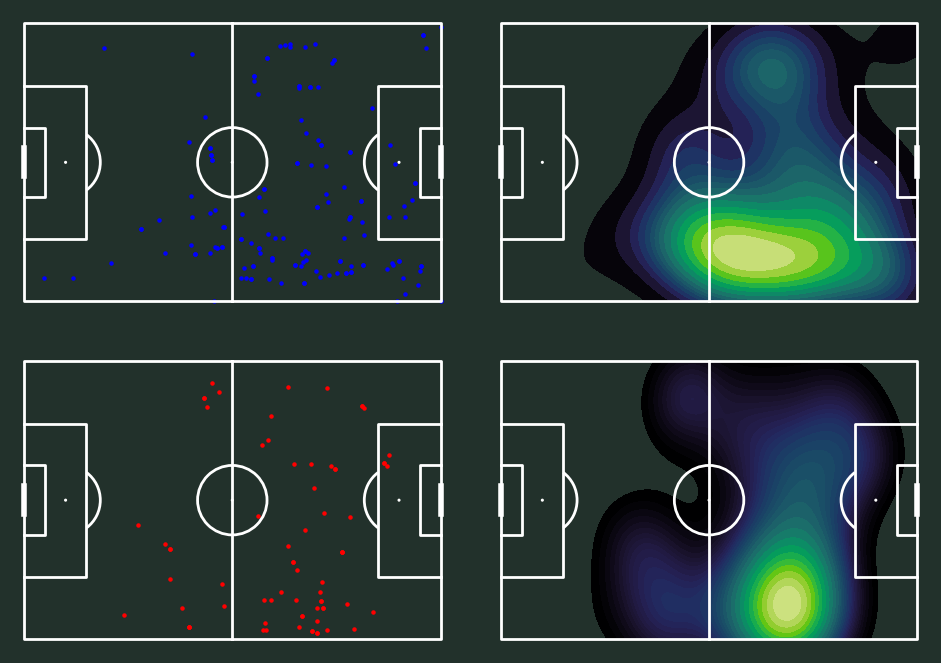

In [9]:
fig, axs = pitch.grid(nrows = 2, ncols = 2, space = 0.05, title_height = 0, endnote_height = 0)
fig.set_facecolor('#22312b')
# 1ª part
axs[0, 0].scatter(half1.x, half1.y, c = 'b', s = 5)
pitch.kdeplot(half1.x, half1.y, ax = axs[0, 1], cmap = cmap, fill = True, levels = 16)
# 2ª part
axs[1, 0].scatter(half2.x, half2.y, c = 'r', s = 5)
pitch.kdeplot(half2.x, half2.y, ax = axs[1, 1], cmap = cmap, fill = True, levels = 32);

#### Heatmap (amb scipy.gaussian_kde())

- obviament pitch.kde() és una funció molt específica de *mplsoccer* per representar mapes de calor
- en general utilitzarem la funció **gaussian_kde()** del mòdul *scipy.stats*

In [10]:
from scipy.stats import gaussian_kde

#### Estimació del model (pdf)

- el model s'estima sobre les dades conegudes (la mostra)
- gaussian_kde() espera una matriu d'entrada de (#dim, #obs), per tant hem de transposar les matrius de dades
- transposar una matriu vol dir canviar files per columnes, np.transpose() or np.array().T
- gaussian_kde() no admet nans a la matriu de dades

In [11]:
gkde_half1 = gaussian_kde(half1.dropna().transpose())
gkde_half2 = gaussian_kde(half2.dropna().T)

#### Avaluació del model

- avaluar el model en un punt significa que el model ens torni el valor de densitat en aquell punt
- el model s'avalua sobre tot el domini
- en aquest cas el domini és tot el camp (considerem un camp de mida sobre la mitja: 105m de llargada x 70m d'amplada)
- el camp el dividim en cel.les

In [12]:
x, y = np.linspace(0, 105, 106), np.linspace(0, 70, 71)
x.shape, y.shape, x, y

((106,),
 (71,),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46.

- tenim 106 * 71 = 7526 cel.les en total
- els punts on hem d'avaluar el model són les coordenades de cada una d'aquestes cel.les

##### Opció A (punt a punt)

In [35]:
%%time
Z1 = np.zeros(x.shape[0] * y.shape[0]).reshape(x.shape[0], y.shape[0])
Z2 = np.zeros(x.shape[0] * y.shape[0]).reshape(x.shape[0], y.shape[0])
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        Z1[i, j] = gkde_half1.evaluate((xi, yj))[0]
        Z2[i, j] = gkde_half2.evaluate((xi, yj))[0]

CPU times: user 1.29 s, sys: 517 ms, total: 1.81 s
Wall time: 1.05 s


- Per fer un plot d'un kde podem fer servir la funció **plt.pcolormesh()** de *matplotlib.pyplot*
- Atenció que em posat les x com files i les y com columnes !!
- Hem de transposar les matrius Z

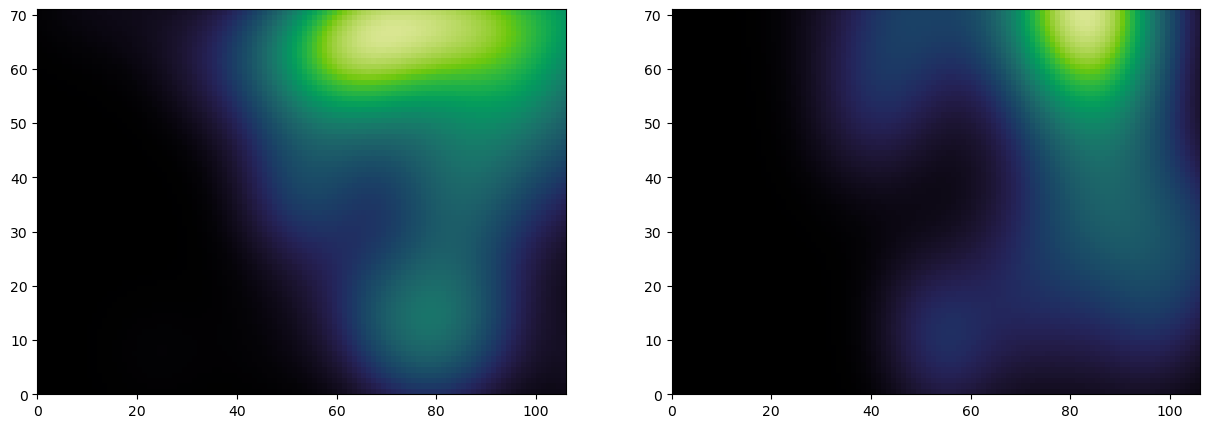

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].pcolormesh(Z1.T, cmap = cmap                )
axs[1].pcolormesh(Z2.T, cmap = cmap);

- l'ordre de les files està a l'inrevés !!
- podem girar arrays amb les funcions np.fliplr(), np.flipud()

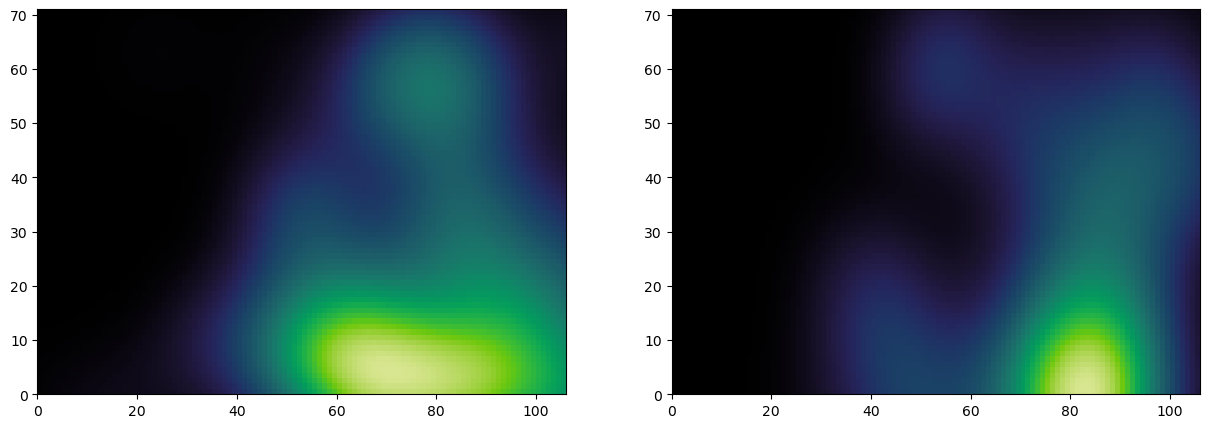

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].pcolormesh(np.flipud(Z1.T), cmap = cmap)
axs[1].pcolormesh(np.flipud(Z2.T), cmap = cmap);

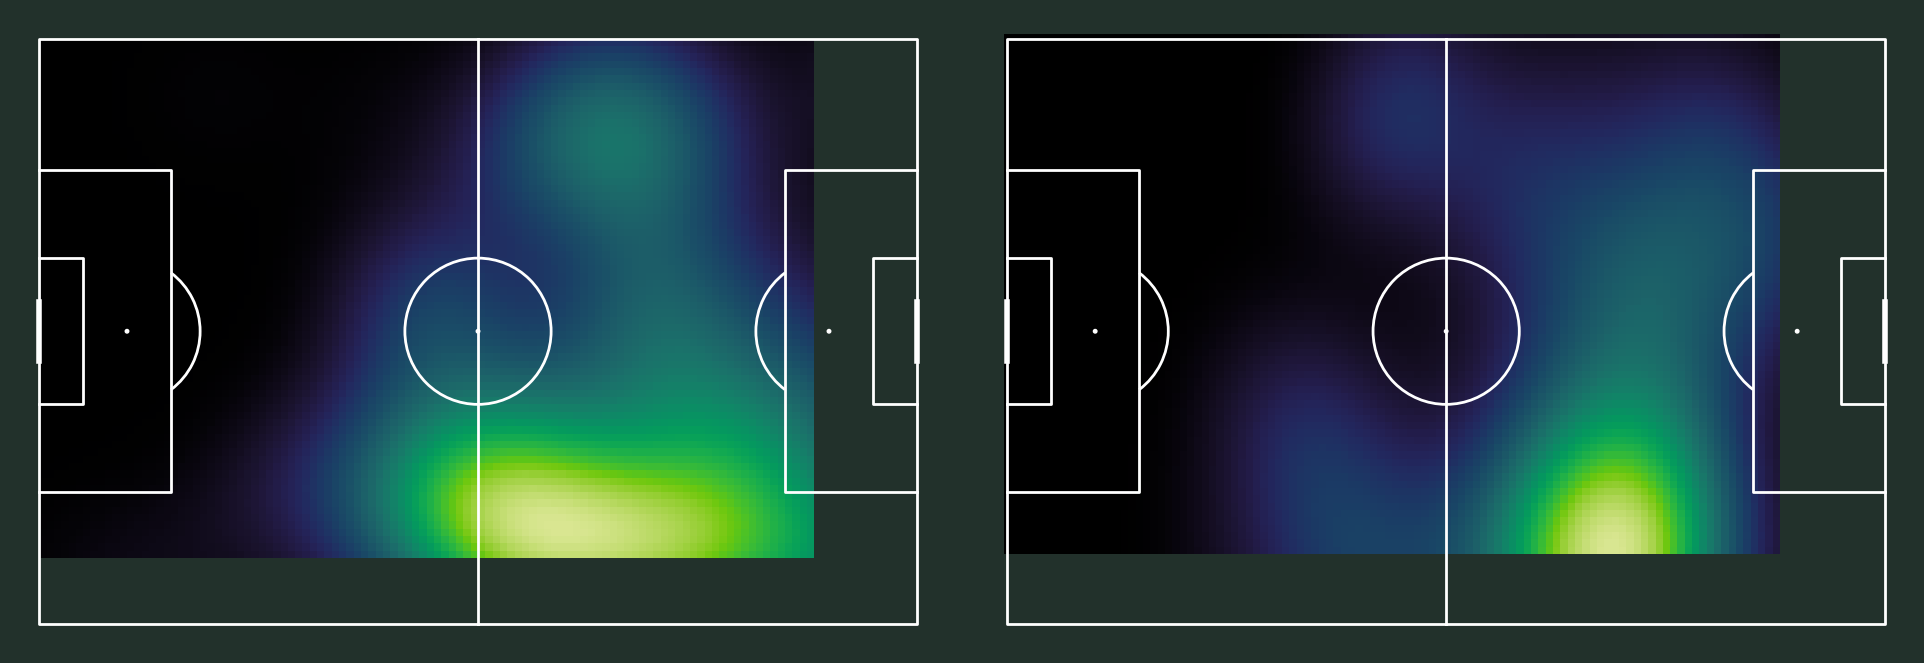

In [37]:
fig, axs = pitch.grid(nrows = 1, ncols = 2, space = 0.05, title_height = 0, endnote_height = 0)
fig.set_facecolor('#22312b')
axs[0].pcolormesh(Z1.T, cmap = cmap)
axs[1].imshow(Z2.T, cmap = cmap);

##### Opció B  (meshgrid)

- np.meshgrid() ens permet muntar una matriu amb les combinacions de coordenades de totes les cel.les
- aquesta matriu la podem avaluar tota de cop

In [16]:
X, Y = np.meshgrid(x, y)
X.shape, Y.shape

((71, 106), (71, 106))

In [17]:
X, Y

(array([[  0.,   1.,   2., ..., 103., 104., 105.],
        [  0.,   1.,   2., ..., 103., 104., 105.],
        [  0.,   1.,   2., ..., 103., 104., 105.],
        ...,
        [  0.,   1.,   2., ..., 103., 104., 105.],
        [  0.,   1.,   2., ..., 103., 104., 105.],
        [  0.,   1.,   2., ..., 103., 104., 105.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        ...,
        [68., 68., 68., ..., 68., 68., 68.],
        [69., 69., 69., ..., 69., 69., 69.],
        [70., 70., 70., ..., 70., 70., 70.]]))

- *np.ravel()* és una funció que fa el mateix que *np.flatten()*
- la diferència és que *np.flatten()* fa una còpia en memòria mentres que *np.ravel()* és només un view (no utilitza memòria adicional)

In [18]:
points = np.vstack([X.ravel(), Y.ravel()])
points.shape, points

((2, 7526),
 array([[  0.,   1.,   2., ..., 103., 104., 105.],
        [  0.,   0.,   0., ...,  70.,  70.,  70.]]))

- avaluem el model en tot aquest array de punts de cop

In [19]:
%%time
Z_half1 = gkde_half1.evaluate(points)
Z_half2 = gkde_half2.evaluate(points)

CPU times: user 39.6 ms, sys: 235 µs, total: 39.9 ms
Wall time: 37 ms


- Z és un vector amb els valors de densitat per cada una de les cel.les

In [20]:
Z_half1.shape, Z_half2.shape

((7526,), (7526,))

- per fer el heatmap ho hem de reconvertir al *shape* de cel.les amb el que hem dividit el camp (71 x 106)
- aquest shape és el de X o Y

In [21]:
Z_half1 = Z_half1.reshape(X.shape)
Z_half2 = Z_half2.reshape(X.shape)
Z_half1.shape, Z_half2.shape

((71, 106), (71, 106))

- en aquest cas, per fer el plot no cal fer la transposició de la matriu Z (només girar-la)

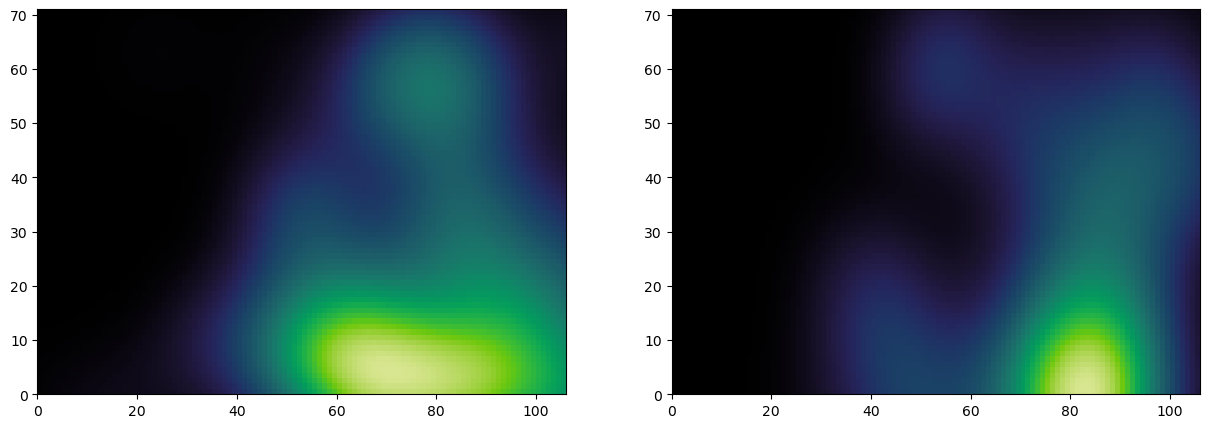

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].pcolormesh(np.flipud(Z_half1), cmap = cmap)
axs[1].pcolormesh(np.flipud(Z_half2), cmap = cmap);

- també podem fer el plot del heatmap amb la funció **np.imshow()**
- per les imatges l'origen de coordenades és sempre a dalt a l'esquerra, per tant quan utilitzem *np.imshow()* no cal girar les Z

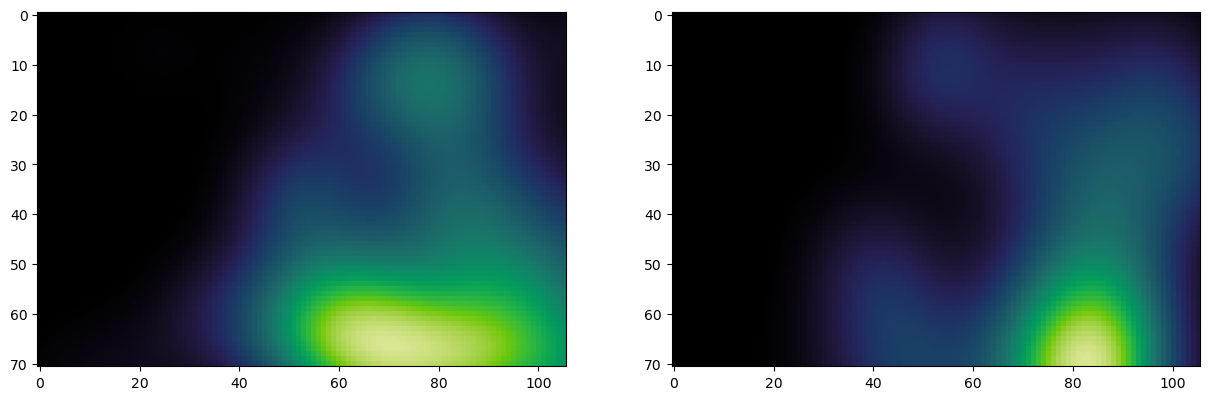

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(Z_half1, cmap = cmap)
axs[1].imshow(Z_half2, cmap = cmap);

#### El paràmetre *bandwidth*

- determina la "dispersió" del kernel (la *variança* en cas d'un kernel Gaussià)
- com més gran és el *bandwidth* més es dispersa la probabilitat

In [32]:
from sklearn.neighbors import KernelDensity

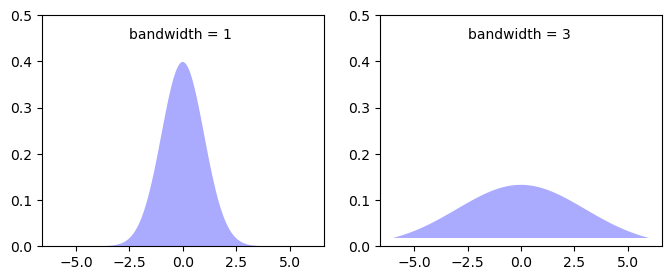

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (8, 3))

input_ = np.zeros((1, 1))
sample = np.linspace(-6, 6, 1000)[:, None]

# bandwidth = 1
log_density = KernelDensity(kernel = 'gaussian', bandwidth = 1.0).fit(input_).score_samples(sample)
density = np.exp(log_density)
axs[0].fill(sample[:, 0], density, "-k", fc="#AAAAFF")
axs[0].set_ylim(0, 0.5)
axs[0].text(-2.5, 0.45, 'bandwidth = 1')

# bandwidth = 3
log_density = KernelDensity(kernel = 'gaussian', bandwidth = 3.0).fit(input_).score_samples(sample)
density = np.exp(log_density)
axs[1].fill(sample[:, 0], density, "-k", fc="#AAAAFF")
axs[1].set_ylim(0, 0.5)
axs[1].text(-2.5, 0.45, 'bandwidth = 3');

In [26]:
# default bandwidth: Scott's rule
n = len(half1)
d = 2
n**(-1./(d +4))

0.431464150587417

In [27]:
gkde_scott = gaussian_kde(half1.dropna().T, bw_method = 'scott')
gkde_2scott = gaussian_kde(half1.dropna().T, bw_method = 0.86)

In [28]:
Z1 = gkde_scott.evaluate(points)
Z2 = gkde_2scott.evaluate(points)

In [29]:
Z1 = Z1.reshape(X.shape)
Z2 = Z2.reshape(X.shape)

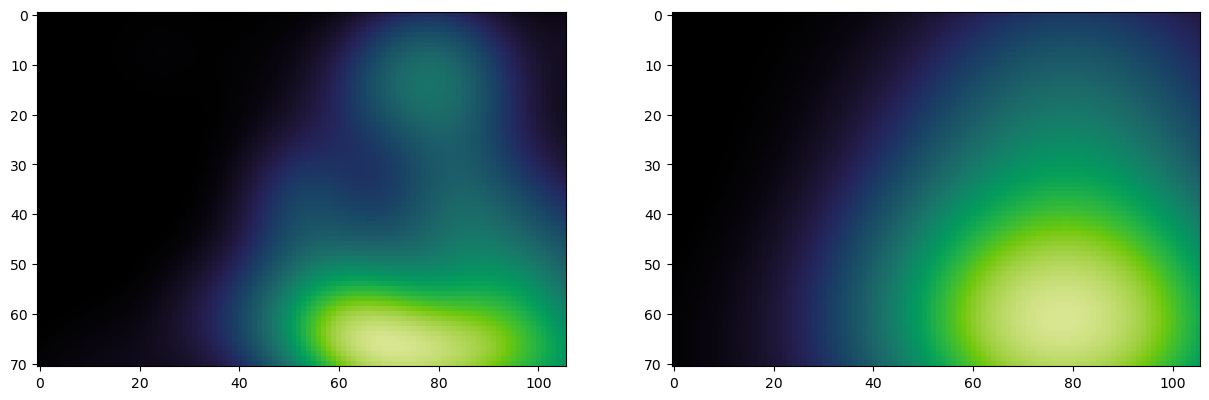

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(Z1, cmap = cmap)
axs[1].imshow(Z2, cmap = cmap);

#### Tornem al heatmap del futbol

- podem utilitzar qualsevol de les funcions plt.pcolormesh(), np.imshow() sobre una instància de **Pitch** del *mplsoccer* per veure com queda sobre el camp

- en qualsevol cas aquí no cal girar les Z

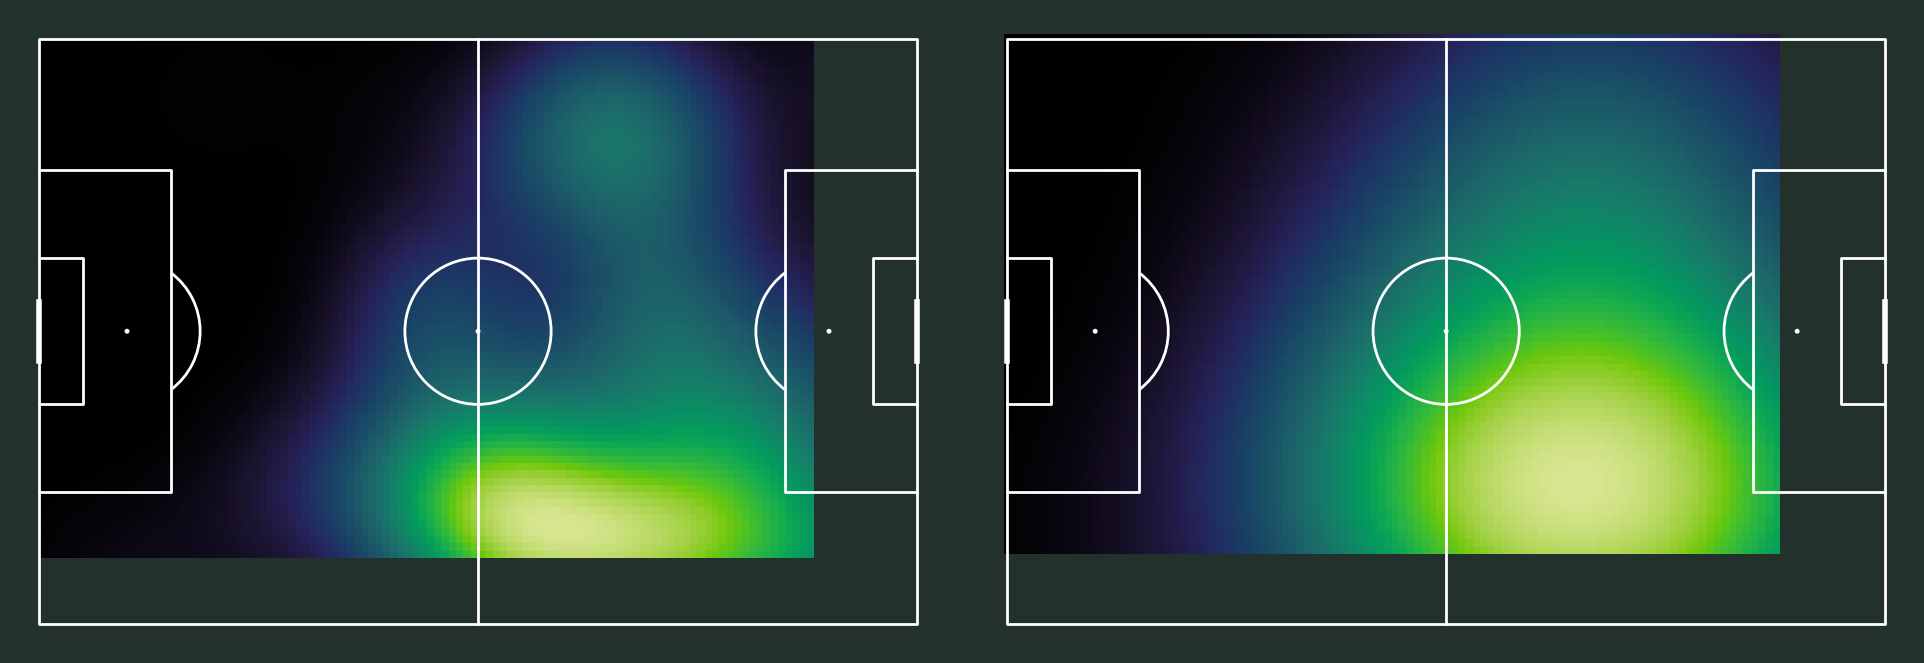

In [34]:
fig, axs = pitch.grid(nrows = 1, ncols = 2, space = 0.05, title_height = 0, endnote_height = 0)
fig.set_facecolor('#22312b')
axs[0].pcolormesh(Z1, cmap = cmap)
axs[1].imshow(Z2, cmap = cmap);

#### Què ha passat aquí ????

- Busqueu la sol.lució